This script will create a tiled version of a raster dataset, it is expected that the input imagery is either one large raster or multible edge matched rasters of the same resolution. You are able to define the size of the tiles and the amount of overlap between tiles.

In [1]:
import os
import subprocess
from pathlib import Path

import math
from pathlib import Path
from tqdm.auto import tqdm
from multiprocess import Pool,cpu_count
%matplotlib inline

from osgeo import gdal,osr
import geopandas as gpd
from shapely import geometry
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
tile_size_px = [500,500] #x,y
tile_oxerlap_px = 150

geotiff_folder = '/data/Bike paths/inf image'
output_folder = '/data/Bike paths/inf tiles'
print('Geotiff folder good?', os.path.isdir(geotiff_folder))
print('Output folder good?', os.path.isdir(output_folder))
#if you want to use all of your rasters set the below value to None
valid_rasters_csv = ''
    
input_file_ext = '.tif'
output_compression = 'JPEG'  #use JPEG for images and LZW for raw data 

Geotiff folder good? True
Output folder good? True


In [6]:
# Do you want the output tiles to be nested into row folders?
output_to_row_folders = True
# do you want to append a string to every tile?
raster_name_append = ''

In [7]:
# dump tile setting a a json file into output location
parent_dir = os.path.dirname(output_folder)
settings_file_path = os.path.join(parent_dir,'tiling_settings.json')
settings = {'tile_size_px':tile_size_px,
           'tile_oxerlap_px':tile_oxerlap_px,
           'raster_name_append':raster_name_append,
           'tile_format':'.tif'}
with open(settings_file_path, 'w') as fp:
    json.dump(settings, fp)

In [8]:
Path(output_folder).mkdir(parents=True, exist_ok=True)
os.path.isdir(geotiff_folder)

True

In [9]:
# search folder and all sub folders for 'input_file_ext' files
geo_tiff_list = []
for root, dirs, files in os.walk(geotiff_folder):
    for file in files:
        if file.endswith(input_file_ext):
            geo_tiff_list.append(os.path.join(root, file))
            
print('We found ',len(geo_tiff_list),input_file_ext,'files')

We found  1 .tif files


In [10]:
# if you want to filter our input raster use this
if valid_rasters_csv:
    valid_raster_df = pd.read_csv(valid_rasters_csv)
    print(valid_raster_df.head())

In [11]:
# convert the valid raster names into a set so the lookup if much faster
if valid_rasters_csv:
    valid_raster_names = set(valid_raster_df.name.tolist())
    valid_raster_names

In [12]:
if valid_rasters_csv:
    short_list = []
    for tif in tqdm(geo_tiff_list):
    #     my csv file does not have the file extension so we are stripping out the '.tif' to find a match
        file_name = os.path.basename(tif)#.replace('.tif','') 
    #     check if the current raster is in the list, if so add it to the clean list
        if file_name in valid_raster_names:
            short_list.append(tif)
    # reset the full list to the clean list        
    geo_tiff_list = short_list
    print(len(geo_tiff_list))

In [13]:
def get_bounds(tif_path):
#     open file
    data = gdal.Open(tif_path)
#     grab bounds
    geoTransform = data.GetGeoTransform()
    left = geoTransform[0]
    top = geoTransform[3]
    right = left + geoTransform[1] * data.RasterXSize
    bottom = top + geoTransform[5] * data.RasterYSize
#     build dict to file bounds
    geo_tiff_bounds_dict = {'top':top,'left':left,'bottom':bottom,'right':right,'tif_path':tif_path}
    return geo_tiff_bounds_dict

In [14]:
# test the above function by returning the bounds of the first raster
geo_tiff_bounds = get_bounds(geo_tiff_list[0])
geo_tiff_bounds

{'top': 6458672.2708,
 'left': 394793.631,
 'bottom': 6457734.1941,
 'right': 395827.8306,
 'tif_path': '/data/Bike paths/inf image/inf clip.tif'}

In [15]:
# use multiprocessing to extract raster bounds
with Pool() as pool:
    geo_tiff_bounds = list(tqdm(pool.imap(get_bounds, geo_tiff_list), total=len(geo_tiff_list)))

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# make new array with only bounds to extract full raster extents
pure_bounds = []
for geo_tif_bounds in geo_tiff_bounds:
    pure_bounds.append([geo_tif_bounds['top'],geo_tif_bounds['left'],geo_tif_bounds['bottom'],geo_tif_bounds['right']])
# convert into numpy array
pure_bounds_np = np.array(pure_bounds)
# grab max extents
bound_y_max = float(pure_bounds_np[:,0].max()) #top
bound_x_min = float(pure_bounds_np[:,1].min()) #left
bound_y_min = float(pure_bounds_np[:,2].min()) #bottom
bound_x_max = float(pure_bounds_np[:,3].max()) #right

In [17]:
'top',bound_y_max,'left',bound_x_min

('top', 6458672.2708, 'left', 394793.631)

In [18]:
# open one image to get the pixel size, this is necessary to know how to cut the rasters
test_raster = gdal.Open(geo_tiff_list[0])
test_raster_gt =test_raster.GetGeoTransform()
pixel_size_x = test_raster_gt[1]
pixel_size_y = test_raster_gt[5]
print(pixel_size_x,pixel_size_y)

0.1499926903553289 -0.14999627438440877


In [19]:
proj = osr.SpatialReference(wkt=test_raster.GetProjection())
crs = 'EPSG:'+proj.GetAttrValue('AUTHORITY',1)
crs

'EPSG:7850'

In [20]:
# calculate the geographical distance in each direction each tile must be from the last tile
x_move = pixel_size_x*(tile_size_px[0]-tile_oxerlap_px)
y_move = pixel_size_y*(tile_size_px[1]-tile_oxerlap_px)
print(x_move,y_move)

# calculate the geographical size of each tile
x_tile_size = pixel_size_x*tile_size_px[0]
y_tile_size = pixel_size_y*tile_size_px[1]
print(x_tile_size,y_tile_size)

52.49744162436511 -52.498696034543066
74.99634517766444 -74.99813719220438


In [21]:
# calculate the number of cols so we can avoid using while loops
number_of_cols = math.ceil(abs((bound_x_max-bound_x_min)/x_move))
number_of_cols

20

In [22]:
# calculate the number of rows so we can avoid using while loops
number_of_rows = math.ceil(abs((bound_y_max-bound_y_min)/y_move))
number_of_rows

18

In [23]:
# will return a list of geotiffs which intersect 
def intersect_tile_with_geotiffs(tile_dict,geo_tiff_bounds):
#     setup set to collect results in, a set is used to avoid duplicates
    intersecting_geotiffs = set()
#     loop over each geotiff
    for geo_bounds in geo_tiff_bounds:
#         check is tile top or bottom is inside geotiff
        if (geo_bounds['top'] > tile_dict['top'] > geo_bounds['bottom'] or 
            geo_bounds['top'] > tile_dict['bottom'] > geo_bounds['bottom']):
#         check if left or right are inside a geotiff
            if geo_bounds['right'] > tile_dict['left'] > geo_bounds['left']:
                intersecting_geotiffs.add(geo_bounds['tif_path'])
            if geo_bounds['right'] > tile_dict['right'] > geo_bounds['left']:
                intersecting_geotiffs.add(geo_bounds['tif_path'])
    return intersecting_geotiffs

In [24]:
# will take tile bounds and only export them if they fall within a geotiff
# this is called row by row by pool below
def make_polygons(row):
    tile_polygon_list = []
    tile_top = bound_y_max + y_move*row
    tile_bottom = tile_top + y_tile_size
    tile_left = bound_x_min

    for col in range(0,number_of_cols):
        tile_left = bound_x_min + col*x_move
        tile_right = tile_left + x_tile_size
        tile_dict = {'top':tile_top,'left':tile_left,'bottom':tile_bottom,'right':tile_right}
        tile_list = np.array([tile_top,tile_left,tile_bottom,tile_right])
#         check if valid tile
        intersect = intersect_tile_with_geotiffs(tile_dict,geo_tiff_bounds)
        raster_name = raster_name_append+str(row)+'_'+str(col)+'.tif'
        if len(intersect) > 0:
            polygon = {'geometry':geometry.Polygon([[tile_left, tile_top], [tile_right, tile_top], [tile_right, tile_bottom], [tile_left, tile_bottom]]),
                      'intersect':intersect, 'row':row, 'col':col, 'name':raster_name}
            tile_polygon_list.append(polygon)
    return tile_polygon_list

In [25]:
# multiprocess making polygons
with Pool() as pool:
    tile_polygon_list = list(tqdm(pool.imap(make_polygons, range(0,number_of_rows)), total=len(range(0,number_of_rows))))

# this is returned as a list of list so it must be flattened
tile_polygon_list = list(np.concatenate(tile_polygon_list).ravel())

  0%|          | 0/18 [00:00<?, ?it/s]

In [26]:
%%time
#  convert into geodataframe
polygon_tiles_gpd = gpd.GeoDataFrame(tile_polygon_list,geometry='geometry',crs=crs)
del polygon_tiles_gpd['intersect']

CPU times: user 13 ms, sys: 436 µs, total: 13.4 ms
Wall time: 13.2 ms


In [27]:
polygon_tiles_gpd

,geometry,row,col,name
0,"POLYGON ((394793.631 6458672.271, 394868.627 6...",0,0,0_0.tif
1,"POLYGON ((394846.128 6458672.271, 394921.125 6...",0,1,0_1.tif
2,"POLYGON ((394898.626 6458672.271, 394973.622 6...",0,2,0_2.tif
3,"POLYGON ((394951.123 6458672.271, 395026.120 6...",0,3,0_3.tif
4,"POLYGON ((395003.621 6458672.271, 395078.617 6...",0,4,0_4.tif
...,...,...,...,...
355,"POLYGON ((395581.093 6457779.793, 395656.089 6...",17,15,17_15.tif
356,"POLYGON ((395633.590 6457779.793, 395708.586 6...",17,16,17_16.tif
357,"POLYGON ((395686.088 6457779.793, 395761.084 6...",17,17,17_17.tif
358,"POLYGON ((395738.585 6457779.793, 395813.581 6...",17,18,17_18.tif


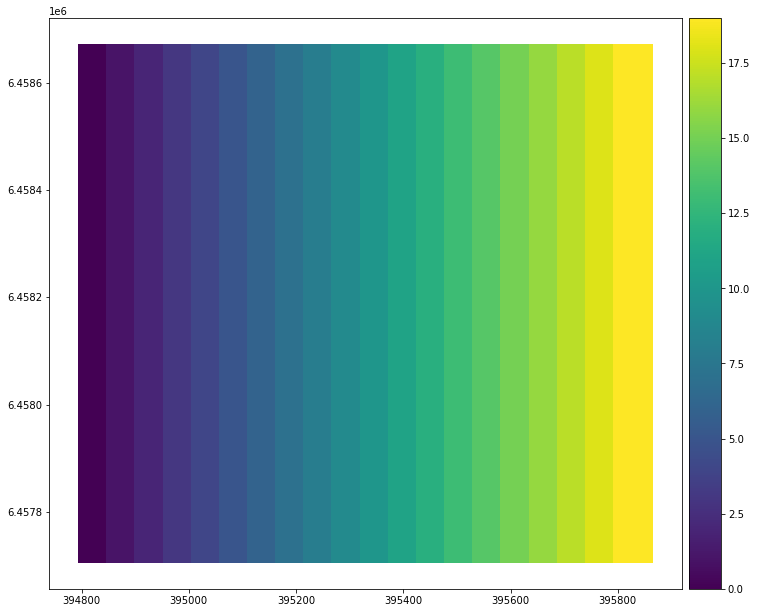

In [28]:
# plot up a bunch of polygons
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
polygon_tiles_gpd.head(10000).plot(column='col', ax=ax, legend=True,cax=cax);

<AxesSubplot:>

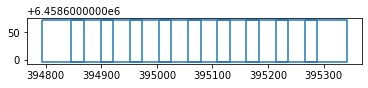

In [29]:
# plot a small number of polygon bounds
polygon_tiles_gpd.head(10).boundary.plot()

In [33]:
polygon_export_loc = output_folder+'_polygons.gpkg'
polygon_export_loc

'/data/Bike paths/inf tiles_polygons.gpkg'

In [34]:
polygon_tiles_gpd.to_file(polygon_export_loc, driver="GPKG")    

In [35]:
# make a list of which tiles are within which geotiffs
def intersector(geo_tiff):
    tiles_inside_geo_tiff = []
#     loop over each tile and check if the geotiff is the the intersect list
    for tile in tile_polygon_list:
        if geo_tiff in tile['intersect']:
#             count this so we know if the tile will be incomplete or not
            incomplete = len(tile['intersect'])>1
#             build dict with geom the current row and col for naming
            tiles_inside_geo_tiff.append({'geometry':tile['geometry'],'row':tile['row'],'col':tile['col'],'name':tile['name'],'incomplete':incomplete})
    return([geo_tiff,tiles_inside_geo_tiff])  

In [36]:
with Pool() as pool:
    geo_tiff_with_tiles = list(tqdm(pool.imap(intersector, geo_tiff_list), total=len(geo_tiff_list)))

  0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
# cut tiles from rasters
def cut_tiles(geotiff):
#     grab path to to file and open it
    geotiff_open = gdal.Open(geotiff[0])
#     grab the filename and strip the extension
    geo_tiff_filename = os.path.basename(geotiff[0]).replace(input_file_ext,'')
    incomplete_tile_list = []
    for tile in geotiff[1]:
        tile_geometry = tile['geometry']
#         shapely bounds returns "minx, miny, maxx, maxy" but we need minx, maxy, maxx, miny
        top = list(tile_geometry.bounds)[3]
        bottom = list(tile_geometry.bounds)[1]
        left = list(tile_geometry.bounds)[0]
        right =list(tile_geometry.bounds)[2]
        
#         make row folder path
        if output_to_row_folders:
            output_row_folder = os.path.join(output_folder,str(tile['row']))
            Path(output_row_folder).mkdir(parents=True, exist_ok=True)
        else:
            output_row_folder = output_folder
#       make row folder if necessary
        
        export_file_name = str(tile['name'])#str(tile['row'])+'_'+str(tile['col'])+'.tif'
        
#         check if tile is incomplete if so append the getiff name so that it is unique
        if tile['incomplete']:
            append_name = '-'+geo_tiff_filename+'_incomplete.tif'
            export_file_name = export_file_name.replace('.tif',append_name)
#             add tile to list so we dont need to refind them to compile incomplete tiles
            export_file_path = os.path.join(output_row_folder,export_file_name)
            incomplete_tile_list.append(export_file_path)
        else:
            export_file_path = os.path.join(output_row_folder,export_file_name)
        
#         check if already done
        if not os.path.isfile(export_file_path):

    #     clip the data
    #         make a string of tile dims to pass as a command line arg, this is kinda of hacky, would like a better option
            tile_clip_string = str(left) +' '+str(top) +' '+str(right) +' '+str(bottom)

            translate_options = gdal.TranslateOptions(gdal.ParseCommandLine("-projwin "+tile_clip_string)
                                                     ,creationOptions=['COMPRESS='+output_compression])

            tile_clip = gdal.Translate(export_file_path, geotiff_open, options = translate_options)
    #     close the tile
            tile_clip = None
    return incomplete_tile_list

In [38]:
# used to slip a list into n chunks of roughly the same size
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [39]:
# set this to cpu_count() unless you are running out of RAM in which case decrease it
concurrent_threads = cpu_count()
concurrent_threads

8

In [40]:
tile_count = 0
for raster,tiles in geo_tiff_with_tiles:
    tile_count+=len(tiles)
average_tile_count = round(tile_count/len(geo_tiff_with_tiles))
average_tile_count

360

In [41]:
# if you have more cores than rasters and more cores than average tile count then give every core a copy of the same raster to work on
if concurrent_threads > len(geo_tiff_with_tiles) and concurrent_threads < average_tile_count:
    print('You have more threads than rasters so we each thread will get the same raster')
    incomplete_tile_list = []

    for raster,tiles in tqdm(geo_tiff_with_tiles):
        geo_tiff_with_tile_list = []

        for tile_split in split(tiles,concurrent_threads):
            geo_tiff_with_tile_list.append([raster,tile_split])

        pool = Pool(concurrent_threads)
        with pool:
            one_raster_incomplete_tile_list = list(pool.imap(cut_tiles,geo_tiff_with_tile_list))

        incomplete_tile_list.append(np.concatenate(one_raster_incomplete_tile_list))
    
else:
    print('you have more rasters than threads so each thread will get its own raster')
    pool = Pool()
    with pool:
        incomplete_tile_list = list(tqdm(pool.imap(cut_tiles,geo_tiff_with_tiles), total=len(geo_tiff_with_tiles)))

You have more threads than rasters so we each thread will get the same raster


  0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
#  the pool above returns all the incomplete tiles as a list of list, we need a flat list
flat_incomplete_tile_list = np.concatenate(incomplete_tile_list).ravel()
print(len(flat_incomplete_tile_list),'incomplete tiles')

0 incomplete tiles


In [43]:
# from the flat list make a new list with just rows and cols to filter by
incomplete_tile_file_names = []
for incomplete_tile in flat_incomplete_tile_list:
    incomplete_tile_file_names.append(os.path.basename(incomplete_tile).split('-')[0].replace(raster_name_append,''))

In [44]:
# make a new dataframe with paths and row/cols
incomplete_tile_df = pd.DataFrame(
    {'incomplete_tiles': flat_incomplete_tile_list,
     'row_col': incomplete_tile_file_names
    })

unique_tiles_list = incomplete_tile_df.row_col.unique()

incomplete_tile_df.head()

,incomplete_tiles,row_col


In [45]:
incomplete_tile_df['incomplete_tiles'].to_list()

[]

In [46]:
# handy gdal tool to merge files
def merge_tiles(merge_imgs, output_path):
    merge_command = ['gdal_merge.py', '-o', output_path, '-quiet', '-co','COMPRESS='+output_compression]
    for name in merge_imgs:
        merge_command.append(name)
    subprocess.run(merge_command)

In [47]:
def join_incomplete_tile(unique_tiles):
#     filter the dataframe down to only one row and col
    df_filt = incomplete_tile_df[incomplete_tile_df['row_col']==unique_tiles]
#     get paths as list
    combine_these = df_filt['incomplete_tiles'].tolist()
#     get export name by removing the geotiff names from end
    export_file_name = os.path.basename(combine_these[0]).split('-')[0]+'.tif'
#     grab the folder from the first tile
    export_dir_path = os.path.dirname(combine_these[0])
#     build full export path
    export_full_path = os.path.join(export_dir_path,export_file_name)
#     use gdal gdal_merge.py to merge the tiles
    merge_tiles(combine_these,export_full_path)
#     remove the incomplete tiles and msk files
    for incomplete_tile in combine_these:
        try:
            os.remove(incomplete_tile)
        except:
            print('could not remove')
        if os.path.isfile(incomplete_tile+'.msk'):
            try:
                os.remove(incomplete_tile+'.msk')
            except:
                print('could not remove')    

In [48]:
pool = Pool()
with pool:
    list(tqdm(pool.imap(join_incomplete_tile,unique_tiles_list), total=len(unique_tiles_list)))

0it [00:00, ?it/s]

In [49]:
# if you want you can validate the output of the above code with the below cells, this is probibly not needed in most cases
# from https://github.com/fastai/fastai/blob/master/fastai/vision/utils.py
from PIL import Image
 
def verify_image(fn):
    try:
        im = Image.open(fn)
        im.draft(im.mode, (32,32))
        im.load()
        return True
    except: return fn

In [50]:
all_tiles = []
for root, dirs, files in os.walk(output_folder):
    for file in files:
        if file.endswith('.tif'):
            all_tiles.append(os.path.join(root, file))
len(all_tiles)

360

In [51]:
with Pool():
    failed_tiles = list(tqdm(Pool().imap(verify_image,all_tiles), total=len(all_tiles)))

  0%|          | 0/360 [00:00<?, ?it/s]

In [52]:
for i in set(failed_tiles):
    if not i:
        print(i)